# Imports and Paths

In [1]:
import pandas as pd
import json

In [2]:
import sys
sys.path.append('../../fastai/old/')
from fastai.learner import *
from fastai.column_data import *

In [ ]:
torch.

# Import Data and reshape

In [2]:
with open('../data/all_game_dict.json') as fp:
    all_game_dict = json.load(fp)
with open('../data/all_game_dict_v2.json') as fp:
    all_game_dict_v2 = json.load(fp)
with open('../data/all_game_dict_v3.json') as fp:
    all_game_dict_v3 = json.load(fp)
with open('../data/all_game_dict_v4.json') as fp:
    all_game_dict_v4 = json.load(fp)
all_game_dict.update(all_game_dict_v2)
all_game_dict.update(all_game_dict_v3)
all_game_dict.update(all_game_dict_v4)

In [13]:
all_users_dict = {}
for kys1 in all_game_dict.keys():
    for kys2 in all_game_dict[kys1].keys():
        if kys2 not in all_users_dict:
            all_users_dict[kys2] = {kys1:all_game_dict[kys1][kys2]}
        else:
            all_users_dict[kys2].update({kys1:all_game_dict[kys1][kys2]})

In [38]:
min_rat = 50
hi_rating_user_dict = {}
for kys in all_users_dict.keys():
    if len(all_users_dict[kys]) >= min_rat:
        hi_rating_user_dict[kys] = all_users_dict[kys]
len(all_users_dict), len(hi_rating_user_dict)

(243525, 47388)

In [ ]:
flat_hi_user_rat_dict = {}
for kys in hi_rating_user_dict.keys():
    

In [45]:
df = pd.DataFrame.from_dict(hi_rating_user_dict, orient='index')
df.shape

(47388, 2000)

In [53]:
df_melt = df.reset_index()
df_melt = df_melt.rename(columns={'index':'user'})
df_melt = pd.melt(df_melt, id_vars='index', var_name='game_id', value_name='rating')
df_melt = df_melt.dropna().reset_index(drop=True)

In [64]:
df_melt.head()

,user,game_id,rating
0,-=Yod@=-,174430,10
1,-mIDE-,174430,9
2,0492372665,174430,9
3,0b1_Ita,174430,8
4,0xDEADBEEF,174430,10


Invert json to give recommendations for each user, instead of for each game

In [65]:
df_melt.to_csv('../data/user_ratings_gt50_melt.csv', index=False)

In [46]:
df.to_csv('../data/user_ratings_gt50.csv')

In [49]:
df.loc['protect3f'].notnull().sum()

72

# Collaborative filtering

In [10]:
df_melt = pd.read_csv('../data/user_ratings_gt50_melt.csv')
df_melt.head()

,user,game_id,rating
0,-=Yod@=-,174430,10.0
1,-mIDE-,174430,9.0
2,0492372665,174430,9.0
3,0b1_Ita,174430,8.0
4,0xDEADBEEF,174430,10.0


In [119]:
users = df_melt.user.unique().tolist()
user_ct = 5*10**3
rs_ct = 1
random_users = np.random.RandomState(rs_ct).choice(users, user_ct, False)
df_melt_small = df_melt.loc[df_melt.user.isin(random_users),:].copy()
while df_melt_small.loc[df_melt_small.user=='protect3f'].shape[0] == 0:
    rs_ct+=1
    random_users = np.random.RandomState(rs_ct).choice(users, user_ct, False)
    df_melt_small = df_melt.loc[df_melt.user.isin(random_users),:].copy()
    print(rs_ct)
df_melt_small = df_melt_small.reset_index(drop=True)
df_melt_small.shape[0], df_melt.shape[0]

2
3
4
5
6
7
8
9
10
11
12


(666417, 6296172)

In [61]:
val_idxs = get_cv_idxs(len(df_melt_small))
wd=2e-4
n_factors = 50

In [62]:
path = '../data/'
cf = CollabFilterDataset.from_data_frame(path, df_melt_small, 'user', 'game_id', 'rating') 
# from_csv(path, 'user_ratings_gt50_melt.csv', 'user', 'game_id', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [63]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      1.402592   1.416831  
    1      1.530352   1.509635                                  
    2      1.34832    1.391427                                  


[array([1.39143])]

In [36]:
preds = learn.predict()

In [82]:
idx2user = {v:k for k,v in cf.user2idx.items()}
idx2item = {v:k for k,v in cf.item2idx.items()}

In [107]:
bb = learn.data.val_ds.xs
us_list = []
gm_list = []
for i in range(10):
    us_list.append(idx2user[bb[0][i]])
    gm_list.append(idx2item[bb[1][i]])
df_melt_small.loc[(df_melt_small.user.isin(us_list)) & (df_melt_small.game_id==gm_list[0]),:]

,user,game_id,rating
2,5hrike,174430,10.0
6,AVJax,174430,9.0
7,AddictedTourist,174430,7.0
9,Aden,174430,10.0
11,Aietos,174430,8.0
14,AlexFS,174430,8.0
24,Aoshi312,174430,10.0
31,ArguleonVeq,174430,9.0
32,Arnaudverbeek,174430,10.0
34,Asamoah,174430,10.0


In [110]:
df_melt_small.loc[df_melt_small.user=='protect3f']

,user,game_id,rating
222141,protect3f,97903,6.0
341089,protect3f,150,7.0
403829,protect3f,155703,7.0
584546,protect3f,102652,6.0
775864,protect3f,37046,8.0
810840,protect3f,5,3.0
822617,protect3f,100901,6.0
908441,protect3f,18,7.0
920418,protect3f,146021,5.0
933124,protect3f,96848,8.0


In [65]:
aa[:10]

array([10.,  9.,  7., 10.,  8.,  8., 10.,  9., 10., 10.], dtype=float32)

In [99]:
cc

array([[ 2,  6,  7,  9, 11, 14, 24, 31, 32, 34],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [105]:
cc[0].shape

(10,)

In [98]:
cc = np.array([bb[0][:10], bb[1][:10]])
learn.predict_array(cc)

TypeError: forward() missing 1 required positional argument: 'items'

In [106]:
learn.summary

<bound method CollabFilterLearner.summary of EmbeddingDotBias(
  (u): Embedding(5000, 50)
  (i): Embedding(2000, 50)
  (ub): Embedding(5000, 1)
  (ib): Embedding(2000, 1)
)>

In [93]:
preds[:10]

array([8.39595, 8.52091, 8.27611, 8.46322, 8.38897, 7.88782, 8.85533, 8.27916, 8.30701, 7.87706],
      dtype=float32)

In [71]:
len(set(bb[0]))

5000

In [72]:
df_melt_small.loc[val_idxs,'user'].nunique()

5000

In [57]:
val_idxs[:10]

array([ 17936, 386136, 113465, 402017, 458534, 229775, 469269, 225312, 342223, 498205])

In [56]:
aa[:10]

array([ 8.5, 10. ,  9.5,  9.5, 10. ,  3. ,  8. ,  7.4, 10. ,  7.3], dtype=float32)

In [ ]:
learn.predict_array()

/home/msnow/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


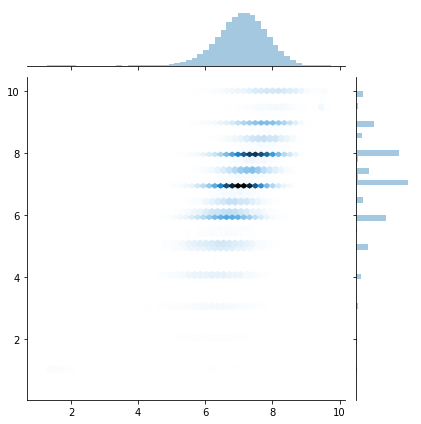

In [38]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

In [ ]:
learn.

In [37]:
preds.shape

(134530,)

In [31]:
user_ct = 10**4
random_users = np.random.choice(users, user_ct, False)
df_melt_med = df_melt.loc[df_melt.user.isin(random_users),:].copy()
df_melt_med.shape[0], df_melt.shape[0]

(1322450, 6296172)

In [32]:
path = '../data/'
cf2 = CollabFilterDataset.from_data_frame(path, df_melt_med, 'user', 'game_id', 'rating') 
learn = cf2.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [33]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      1.413143   1.49899   
    1      1.486003   1.581352                                  
  8%|▊         | 1431/18562 [00:15<02:58, 96.18it/s, loss=1.5] 

KeyboardInterrupt: 